## m2: release

### Setup

In [51]:
import time
from datetime import timedelta

import pandas as pd
import numpy as np
from scipy import stats

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Model infrastructure
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics as sk_metrics

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Reductions
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

# Regressions
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

### 1. Preprocessing

In [52]:
# Load data
df = pd.read_csv('data/red.csv', parse_dates=['release']).drop(columns=['popularity'])
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 12000 rows, 519 columns
Data test: 3000 rows, 519 columns


In [53]:
# Drop NA values
n_orig = df_train.shape[0]
n_na = df_train['release'].isna().sum()
df_train = df_train.dropna(subset=['release'])
print(f'Train set: Dropped {n_na} NA entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_na = df_test['release'].isna().sum()
df_test = df_test.dropna(subset=['release'])
print(f'Test set: Dropped {n_na} NA entries of {n_orig}, {df_test.shape[0]} entries left.')

Train set: Dropped 4158 NA entries of 12000, 7842 entries left.
Test set: Dropped 1022 NA entries of 3000, 1978 entries left.


Train set: Dropped 71 <1990 entries of 7842, 7771 entries left.
Test set: Dropped 17 <1990 entries of 1978, 1961 entries left.


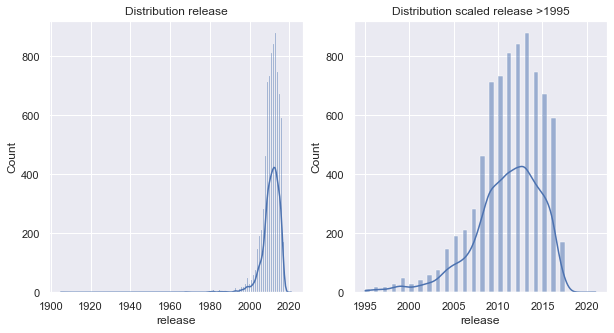

In [54]:
# Bin y per year
df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

# Throw out values <1980
# y_train_before = df_train['release']
# n_orig = df_train.shape[0]
# n_under = df_train.loc[df_train['release']<1995].shape[0]
# df_train = df_train.loc[df_train['release']>=1995]
# y_train = df_train['release']
# print(f'Train set: Dropped {n_under} <1990 entries of {n_orig}, {df_train.shape[0]} entries left.')
# n_orig = df_test.shape[0]
# n_under = df_test.loc[df_test['release']<1995].shape[0]
# df_test = df_test.loc[df_test['release']>=1995]
# y_test = df_test['release']
# print(f'Test set: Dropped {n_under} <1990 entries of {n_orig}, {df_test.shape[0]} entries left.')

# fig, axs = plt.subplots(ncols=2, figsize=(10,5))
# ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
# ax1.set(title="Distribution release")
# ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
# ax2.set(title="Distribution scaled release >1995")
# fig;

In [55]:
# Scale X
X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')


Scaled train X:
	mean: [9.1435173820628e-19, -6.40046216744396e-18, 5.02893456013454e-18, 9.1435173820628e-18, -2.74305521461884e-18]...
	std: [1.000064347994018, 1.0000643479940177, 1.0000643479940179, 1.000064347994018, 1.0000643479940179]...
Scaled test X:
	mean: [-0.0107658877562252, 0.026026085532822655, -0.01715146940594983, -0.006026035577929298, -0.010387469044931206]...
	std: [0.028141987255861006, 1.112503016899501, 0.24402137000354107, 0.5800776716685477, 0.2393159462352364]...


### 2. Reductions

In [16]:
# Load data
df = pd.read_csv('data/red.csv',  parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
# df = df.loc[df['release']>=1995]
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9732 rows, 519 columns


In [4]:
# Settings
n_feats = [2, 10, 25, 50, 100, 200, 300, 400, 500]
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

In [5]:
st = time.time()
name = 'lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('mod', LinearRegression())
])

parameters = {}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(518)
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:07


#### RFE - random feature elimination

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [7]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:04:16


#### PCA - principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

In [8]:
st = time.time()
name = 'pca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', PCA(svd_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:00:51


#### KernelPCA - polynomial principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=pca#sklearn.decomposition.KernelPCA)

In [9]:
st = time.time()
name = 'kpca_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', KernelPCA(kernel='poly', degree=2, eigen_solver='arpack', random_state=1)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:11:24


#### ISOmap

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap)

In [12]:
st = time.time()
name = 'iso_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', Isomap(n_neighbors=10, eigen_solver='arpack', path_method='D', neighbors_algorithm='kd_tree')),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_components': n_feats
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_components'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:48:47


#### Results

In [13]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_red_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.95, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.05, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.95, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.05, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
lr,518,-1.615834,37.114979,5.445581,2.955360
rfe_lr,2,-0.002431,14.668619,3.829484,2.954298
rfe_lr,10,0.002685,14.594908,3.819780,2.949503
rfe_lr,25,0.021737,14.310935,3.782652,2.912147
rfe_lr,50,0.051402,13.876847,3.724902,2.862467
rfe_lr,100,0.010410,14.457433,3.799240,2.850054
rfe_lr,200,-0.054696,15.386093,3.913526,2.877318
rfe_lr,300,-0.109361,16.169663,4.014178,2.899733
rfe_lr,400,-1.654096,37.650638,5.484752,2.955173
rfe_lr,500,-1.711678,38.445170,5.503080,2.956871


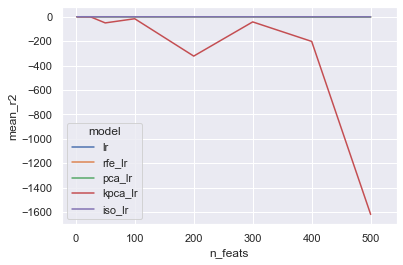

In [14]:
sns.lineplot(data=results, x='n_feats', y='mean_r2', hue='model');

### 3. Regressions

In [17]:
# Load data
df = pd.read_csv('data/reg.csv', parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
# df = df.loc[df['release']>=1995]
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9706 rows, 519 columns


In [18]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### Benchmark

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [19]:
st = time.time()
name = 'rfe_lr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [25, 50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:15


#### Elastic net

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet)

In [20]:
st = time.time()
name = 'rfe_en'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', ElasticNet())
])

parameters = {
    'red__n_features_to_select': [25, 50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:09


#### Polynomial regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial%20features#sklearn.preprocessing.PolynomialFeatures)

In [21]:
st = time.time()
name = 'rfe_pr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('poly', PolynomialFeatures(degree=2)),
    ('mod', LinearRegression())
])

parameters = {
    'red__n_features_to_select': [25, 50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:16


#### SVR - support vector regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR)

In [22]:
st = time.time()
name = 'rfe_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', SVR())
])

parameters = {
    'red__n_features_to_select': [25, 50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:33


#### K-neighbors regression

[scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=k%20neighbors#sklearn.neighbors.KNeighborsRegressor)

In [23]:
st = time.time()
name = 'rfe_kn'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', KNeighborsRegressor(algorithm='kd_tree'))
])

parameters = {
    'red__n_features_to_select': [25, 50]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:01:13


#### Results

In [25]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_reg_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.9, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.1, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.9, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.1, color='green')

model,n_feats,mean_r2,mean_mse,mean_rmse,mean_mae
rfe_lr,25,0.037161,14.280154,3.778502,2.884942
rfe_lr,50,0.064266,13.877505,3.724830,2.842826
rfe_en,25,-0.002073,14.864315,3.854896,2.942517
rfe_en,50,-0.002073,14.864315,3.854896,2.942517
rfe_pr,25,-0.014745,15.072961,3.878945,2.914108
rfe_pr,50,-0.465993,21.750278,4.646468,3.176694
rfe_svr,25,0.043784,14.180645,3.765355,2.817803
rfe_svr,50,0.074027,13.738690,3.705761,2.759457
rfe_kn,25,-0.078524,15.990233,3.998515,3.054605
rfe_kn,50,-0.057243,15.678336,3.959160,3.016858


### 4. Hyperparamter optimization

In [26]:
# Load data
df = pd.read_csv('data/hyper.csv', parse_dates=['release']).drop(columns=['popularity'])

# Preprocess data
df = df.dropna(subset=['release'])
df['release'] = df['release'].dt.year.astype(int)
# df = df.loc[df['release']>=1995]
y = df['release']
X = df.drop(columns=['release'])

print(f'Data: {df.shape[0]} rows, {df.shape[1]} columns')

Data: 9871 rows, 519 columns


In [33]:
metrics = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
scores = {'model':[], 'n_feats':[], 'kernel':[], 'C':[], 'epsilon':[], 'mean_r2':[], 'mean_mse':[], 'mean_rmse':[], 'mean_mae':[]}

#### RFE + SVR

In [28]:
st = time.time()
name = 'rfe_svr'

pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5)),
    ('mod', SVR())
])

parameters = {
    'red__n_features_to_select': [40, 50, 60],
    'mod__kernel': ['linear', 'rbf', 'sigmoid'],
    'mod__C': [0.5, 1],
    'mod__epsilon': [0.5, 1]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring=metrics, refit=False)
grid_search.fit(X, y)

print(f'runtime: {timedelta(seconds=round(time.time() - st))}')

cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['kernel'].append(cv_scores['params'][i]['mod__kernel'])
    scores['C'].append(cv_scores['params'][i]['mod__C'])
    scores['epsilon'].append(cv_scores['params'][i]['mod__epsilon'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

runtime: 0:26:52


KeyError: 'red__n_components'

In [34]:
cv_scores = grid_search.cv_results_
for i in range(len(cv_scores['params'])):
    scores['model'].append(name)
    scores['n_feats'].append(cv_scores['params'][i]['red__n_features_to_select'])
    scores['kernel'].append(cv_scores['params'][i]['mod__kernel'])
    scores['C'].append(cv_scores['params'][i]['mod__C'])
    scores['epsilon'].append(cv_scores['params'][i]['mod__epsilon'])
    scores['mean_r2'].append(cv_scores['mean_test_r2'][i].round(6))
    scores['mean_mse'].append(np.abs(cv_scores['mean_test_neg_mean_squared_error'][i]).round(6))
    scores['mean_rmse'].append(np.abs(cv_scores['mean_test_neg_root_mean_squared_error'][i]).round(6))
    scores['mean_mae'].append(np.abs(cv_scores['mean_test_neg_mean_absolute_error'][i]).round(6))

#### Results

In [35]:
results = pd.DataFrame(scores)
results.to_csv('results/m2_hyper_metrics.csv', index=False)
results.style\
    .hide(axis='index')\
    .highlight_quantile(subset=['mean_r2'], q_left=0.95, color='green')\
    .highlight_quantile(subset=['mean_r2'], q_right=0.05, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_left=0.95, color='red')\
    .highlight_quantile(subset=['mean_mse', 'mean_rmse', 'mean_mae'], q_right=0.05, color='green')

model,n_feats,kernel,C,epsilon,mean_r2,mean_mse,mean_rmse,mean_mae
pca_svr,40,linear,0.500000,0.500000,0.014864,14.761888,3.841192,2.883297
pca_svr,50,linear,0.500000,0.500000,0.025693,14.595748,3.819757,2.862159
pca_svr,60,linear,0.500000,0.500000,0.030945,14.516628,3.809464,2.857543
pca_svr,40,rbf,0.500000,0.500000,0.041803,14.358873,3.788423,2.836212
pca_svr,50,rbf,0.500000,0.500000,0.051949,14.203496,3.768204,2.816707
pca_svr,60,rbf,0.500000,0.500000,0.056551,14.133973,3.759047,2.809097
pca_svr,40,sigmoid,0.500000,0.500000,-55.060587,827.949830,27.689379,13.584672
pca_svr,50,sigmoid,0.500000,0.500000,-37.387793,569.703286,23.393200,11.406256
pca_svr,60,sigmoid,0.500000,0.500000,-30.590306,471.315830,21.345096,10.494018
pca_svr,40,linear,0.500000,1.000000,0.014919,14.761083,3.841099,2.883299


### 5. Final model

In [58]:
# Load data
df_train = pd.read_csv('data/hyper.csv',  parse_dates=['release']).drop(columns=['popularity'])
df_test = pd.read_csv('data/test.csv',  parse_dates=['release']).drop(columns=['popularity'])
df_test = df_test.sample(n=5000, random_state=1)

# Preprocess data
df_train = df_train.dropna(subset=['release'])
df_test = df_test.dropna(subset=['release'])

df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

# df_train = df_train.loc[df_train['release']>=1995]
# df_test = df_test.loc[df_test['release']>=1995]

y_train = df_train['release']
y_test = df_test['release']

X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])

print(f'Data train: {df_train.shape[0]} rows, {df_train.shape[1]} columns')
print(f'Data test: {df_test.shape[0]} rows, {df_test.shape[1]} columns')

Data train: 9961 rows, 519 columns
Data test: 3250 rows, 519 columns


In [59]:
pipeline = Pipeline([
    ('sc', StandardScaler()),
    ('red', RFE(estimator=LinearRegression(), step=5, n_features_to_select=60)),
    ('mod', SVR(kernel='rbf', C=1, epsilon=1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

r2 = round(sk_metrics.r2_score(y_test, y_pred), 6)
mse = round(sk_metrics.mean_squared_error(y_test, y_pred), 6)
mae = round(sk_metrics.mean_absolute_error(y_test, y_pred), 6)
print(f'Final model: R2: {r2}, MSE: {mse}, MAE:{mae}')

Final model: R2: 0.065016, MSE: 21.281368, MAE:2.970213
